In [ ]:
# Analysis workflow adopted & modified from https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html &
# Data collected & inspo from :https://divingintogeneticsandgenomics.com/post/neighborhood-cellular-niches-analysis-with-spatial-transcriptome-data-in-seurat-and-bioconductor/

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

In [ ]:
# Check working directory
import os
os.getcwd()

In [3]:
# Set working directory to where the files are
new_directory = "/homevol/huemail/G000428_MaiLa/20231101__013606__G000428_MaiLa_01112023_B1/output-XETG00068__0010614__Region_1__20231101__013739"
os.chdir(new_directory)

In [8]:
adata = sc.read_10x_h5("cell_feature_matrix.h5")
df = pd.read_csv("cells.csv")
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()

In [9]:
adata

AnnData object with n_obs × n_vars = 159601 × 314
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'

In [10]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [11]:
# CALCULATING QC METRICS
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In [12]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}") # high % indicates non-specific probe binding
print(f"Negative decoding count % : {cwords}") # 

Negative DNA probe count % : 0.0046053315784127784
Negative decoding count % : 0.0026879603283753105


/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

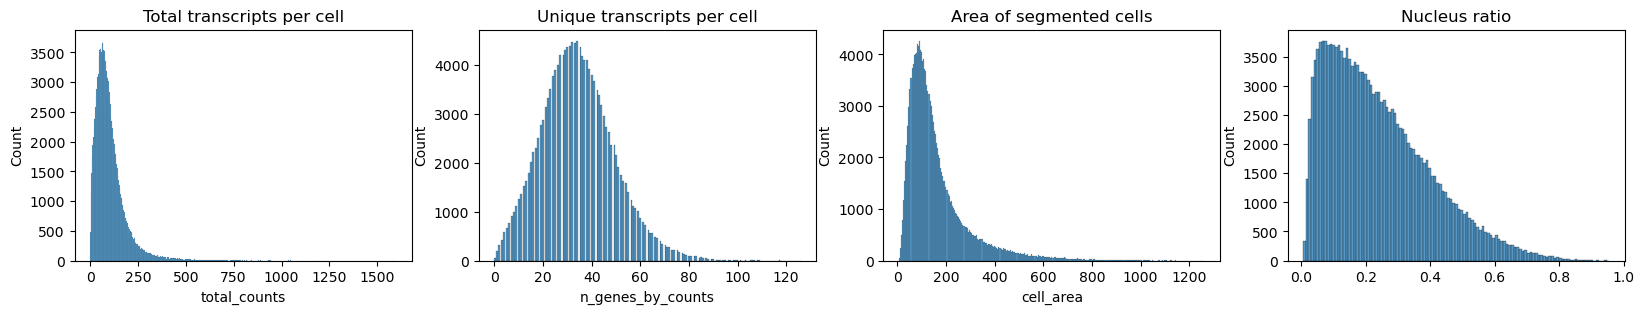

In [13]:
# Plotting QC metrics - again, also provided on the analysis_summary.html
fig, axs = plt.subplots(1, 4, figsize=(20, 3))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 6000.0)

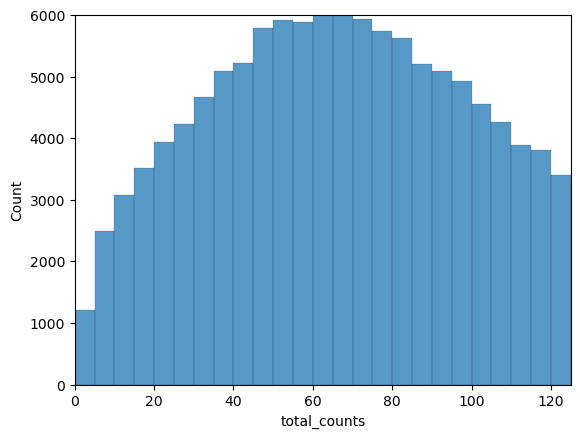

In [15]:
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    binwidth=5)
    #ax=axs[0],)

plt.xlim(0, 125)
plt.ylim(0, 6000)

In [16]:
# Filtering cells/genes based on QC graph above. Filter criteria can be cell area, DAPI signal or minium of unique transcripts
sc.pp.filter_cells(adata, min_counts=10) # The Xenium anlysis summary would help
sc.pp.filter_genes(adata, min_cells=5) #min number of cells expresed required for a gene to pass filtering; min # of counts required for a gene to pass filtering. Using Xenium explorer to help

In [18]:
# Normalisation using default setting
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

# scale the data for visualisation step later
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X

# Dimentionality reduction
# PCA and UMAP
sc.pp.pca(adata) #default = 50PCs

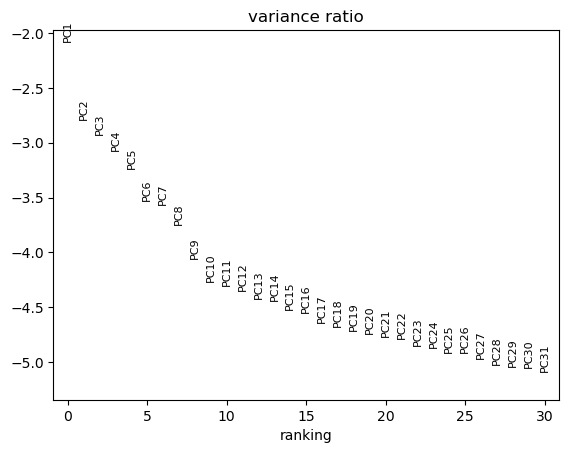

In [22]:
sc.pl.pca_variance_ratio(adata, log=True) # to inspect the contribution of single PCs to the total variance in the data

In [ ]:
# can read more about setting the parameter at https://umap-learn.readthedocs.io/en/latest/parameters.html
sc.pp.neighbors(adata, n_neighbors =15) 
sc.tl.umap(adata)

In [ ]:
# Clustering by leiden, using different resolutions
sc.tl.leiden(adata, resolution = 2.0, key_added = "leiden_2.0")

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


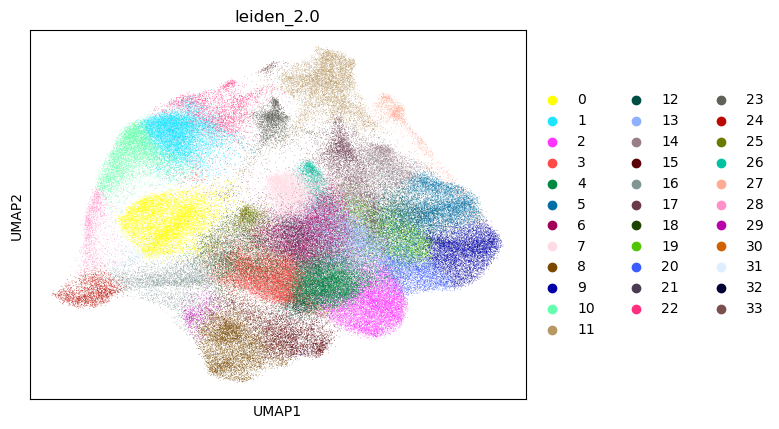

In [26]:
sc.pl.umap(adata, color=['leiden_2.0'])

/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

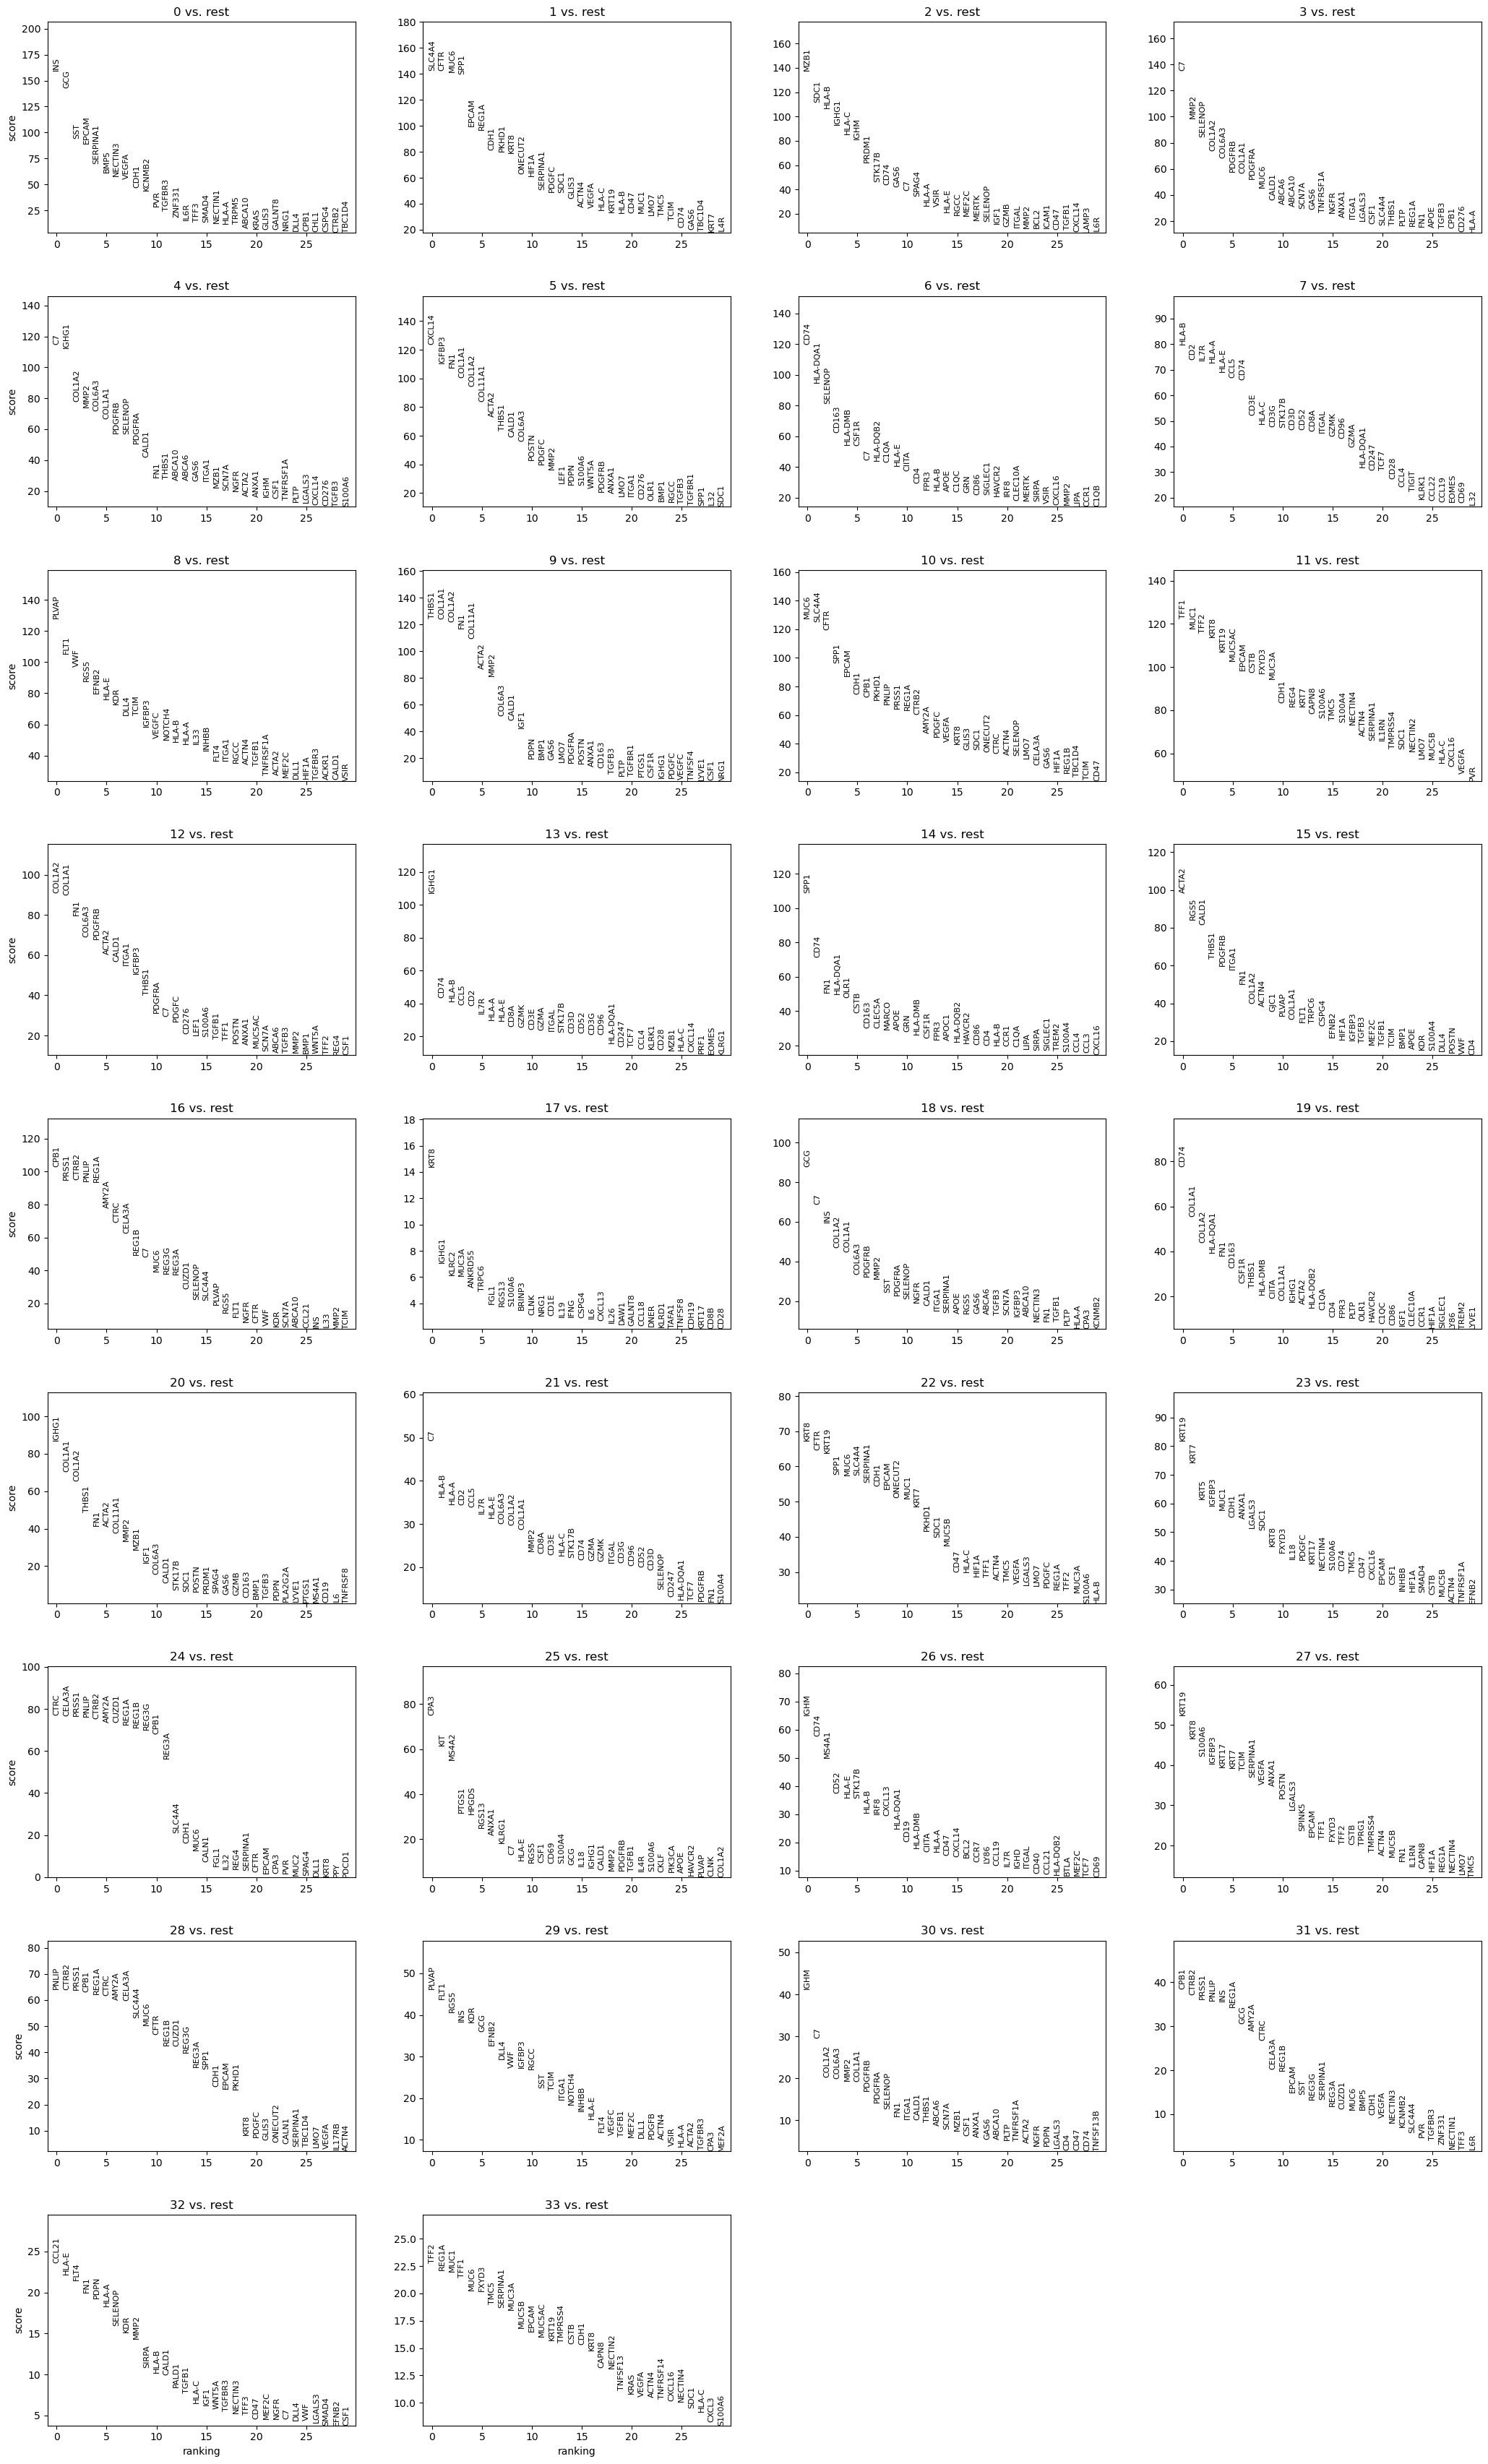

In [28]:
# Find Marker genes
sc.tl.rank_genes_groups(adata, 'leiden_2.0', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


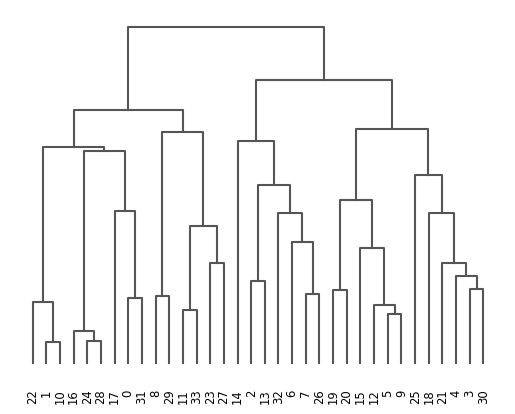

<Axes: >

In [29]:
# Running dendogram
sc.tl.dendrogram(adata, groupby = "leiden_2.0")
sc.pl.dendrogram(adata, groupby = "leiden_2.0")

In [35]:
# CLUSTER ANNOATION - condensed for plotting cellular composition
Lv_1_anno = {
    "22": "Ductal_MUC5B+/MUC6+", 
    "1": "Ductal_MUC5B+/MUC6+", 
    "10": "Ductal_MUC5B+/MUC6+", 
    "16": "Acinar",
    "24": "Acinar", 
    "28": "Acinar",
    "17": "Malignant_epi", 
    "0": "Endocrine", 
    "31": "Acinar", 
    "8": "Endothelial",
    "29": "Endothelial", 
    "11": "Malignant_epi",
    "33": "Malignant_epi",
    "23": "Malignant_epi",
    "27": "Malignant_epi", 
    "14": "TAMs", 
    "2": "Plasma",
    "13": "T/NK",
    "32": "Endothelial",
    "6": "TAMs",
    "7": "T/NK",
    "26": "B",
    "19": "TAMs",
    "20": "CAFs",
    "15": "Vascular smooth muscle",
    "12": "CAFs",
    "5": "CAFs",
    "9": "CAFs",
    "25": "Mast", 
    "18": "Endocrine", 
    "21": "T/NK", 
    "4": "CAFs",
    "3": "CAFs",
    "30":"CAFs" 
}

In [73]:
cluster_anno = { # for nhood enrichment analysis 
    "22": "Ductal_MUC5B+/MUC6+", 
    "1": "Ductal_MUC5B+/MUC6+", 
    "10": "Ductal_MUC5B+/MUC6+", 
    "16": "Acinar", 
    "24": "Acinar_REG+", 
    "28": "Acinar_REG+",
    "17": "Malignant_epi", 
    "0": "Endocrine",
    "31": "Acinar", 
    "8": "Endothelial", 
    "29": "Endothelial", 
    "11": "Malignant_epi", 
    "33": "Malignant_epi", 
    "23": "Malignant_epi",
    "27": "Malignant_epi", 
    "14": "TAMs_s1", # SPP1+/OLR1+
    "2": "Plasma", 
    "13": "T/NK", 
    "32": "Endothelial",  
    "6": "TAMs_s2", # C1QC+ TAM 
    "7": "T/NK", 
    "26": "B", 
    "19": "TAMs_s2", 
    "20": "MYO_CAFs", 
    "15": "Vascular smooth muscle", 
    "12": "MYO_CAFs", 
    "5": "MYO_CXCL14+_CAFs",
    "9": "MYO_CAFs", 
    "25": "Mast", 
    "18": "Endocrine",
    "21": "T/NK",
    "4": "NRT_CAFs",
    "3": "NRT_CAFs",
    "30":"NRT_CAFs"
}

In [37]:
clusters_to_exclude = ['27']  # from other samples
mask_to_keep = ~adata.obs['leiden_2.0'].isin(clusters_to_exclude)
adata_filtered = adata[mask_to_keep, :].copy()

In [39]:
adata = adata_filtered # to remove the cluster

In [40]:
adata.obs["Lv.1.Anno"] = adata.obs['leiden_2.0'].map(Lv_1_anno)
adata.obs['leiden_2.0'].map(Lv_1_anno)

aaaagpjp-1             CAFs
aaaajjem-1    Malignant_epi
aaaakjpn-1             T/NK
aaaaodjn-1             CAFs
aaabdbmm-1           Plasma
                  ...      
oifpnggh-1    Malignant_epi
oigahbdm-1             CAFs
oigaknom-1           Acinar
oigbbegl-1             CAFs
oigbdjgg-1             CAFs
Name: leiden_2.0, Length: 154220, dtype: object

In [41]:
# Check available clusters and their counts
cluster_counts_dense = adata.obs["Lv.1.Anno"].value_counts()
cluster_proportions_dense = cluster_counts_dense / len(adata.obs)

In [42]:
#print(cluster_proportions_dense)
P10614_1 = pd.DataFrame(cluster_counts_dense / len(adata.obs))
P10614_1.columns = ['P10614_1'] # change columne name
P10614_1

P10614_1
Lv.1.Anno                       
CAFs                    0.266891
Ductal_MUC5B+/MUC6+     0.121541
TAMs                    0.107937
T/NK                    0.102594
Endocrine               0.092498
Malignant_epi           0.087550
Plasma                  0.058656
Acinar                  0.055687
Endothelial             0.052659
Vascular smooth muscle  0.029516
Mast                    0.012404
B                       0.012067

In [43]:
from pathlib import Path  
filepath = Path("/homevol/huemail/G000428_MaiLa/output/Submission/CellularComposition/P10614_1.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
P10614_1.to_csv(filepath) 

In [74]:
adata.obs["anno_condense"] = adata.obs['leiden_2.0'].map(cluster_anno)
adata.obs['leiden_2.0'].map(cluster_anno)

aaaagpjp-1         MYO_CAFs
aaaajjem-1    Malignant_epi
aaaakjpn-1             T/NK
aaaaodjn-1         MYO_CAFs
aaabdbmm-1           Plasma
                  ...      
oifpnggh-1    Malignant_epi
oigahbdm-1         MYO_CAFs
oigaknom-1           Acinar
oigbbegl-1         MYO_CAFs
oigbdjgg-1         MYO_CAFs
Name: leiden_2.0, Length: 154220, dtype: object

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype 

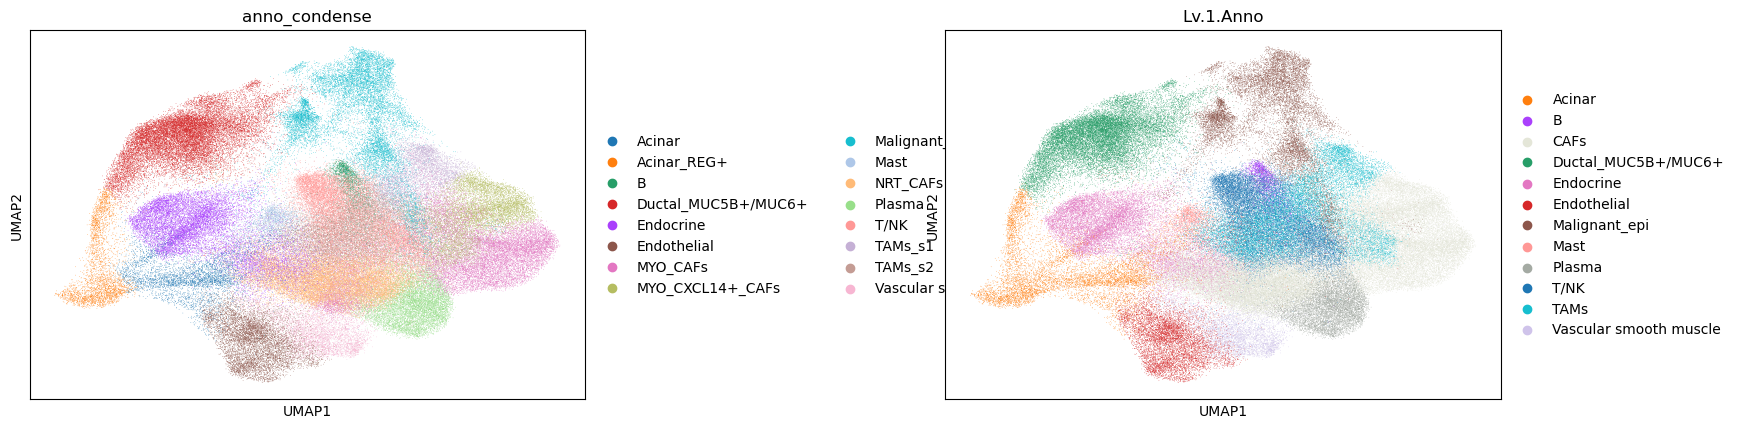

In [75]:
sc.pl.umap(adata, color=[ "anno_condense", "Lv.1.Anno"], wspace = 0.5)

In [ ]:
# Tidy up the metadata
adata.obs['Lv.2.Anno'] = adata.obs['anno_condense'].copy()

# Updating names
update_dic = {
    "MYO_CAFs" : "CAFs_MYO",
    "MYO_CXCL14+_CAFs" : "CAFs_MYO_CXCL14+",
    "NRT_CAFs" : "CAFs_NRT",
    "TAMs_s1" : "TAMs_SPP1+/OLR1+",
    "TAMs_s2" : "TAMs_C1QC+"
}
adata.obs['Lv.2.Anno'] = adata.obs['Lv.2.Anno'].replace(update_dic)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/homevol/huemail/.local/lib/python3.9/site-pa

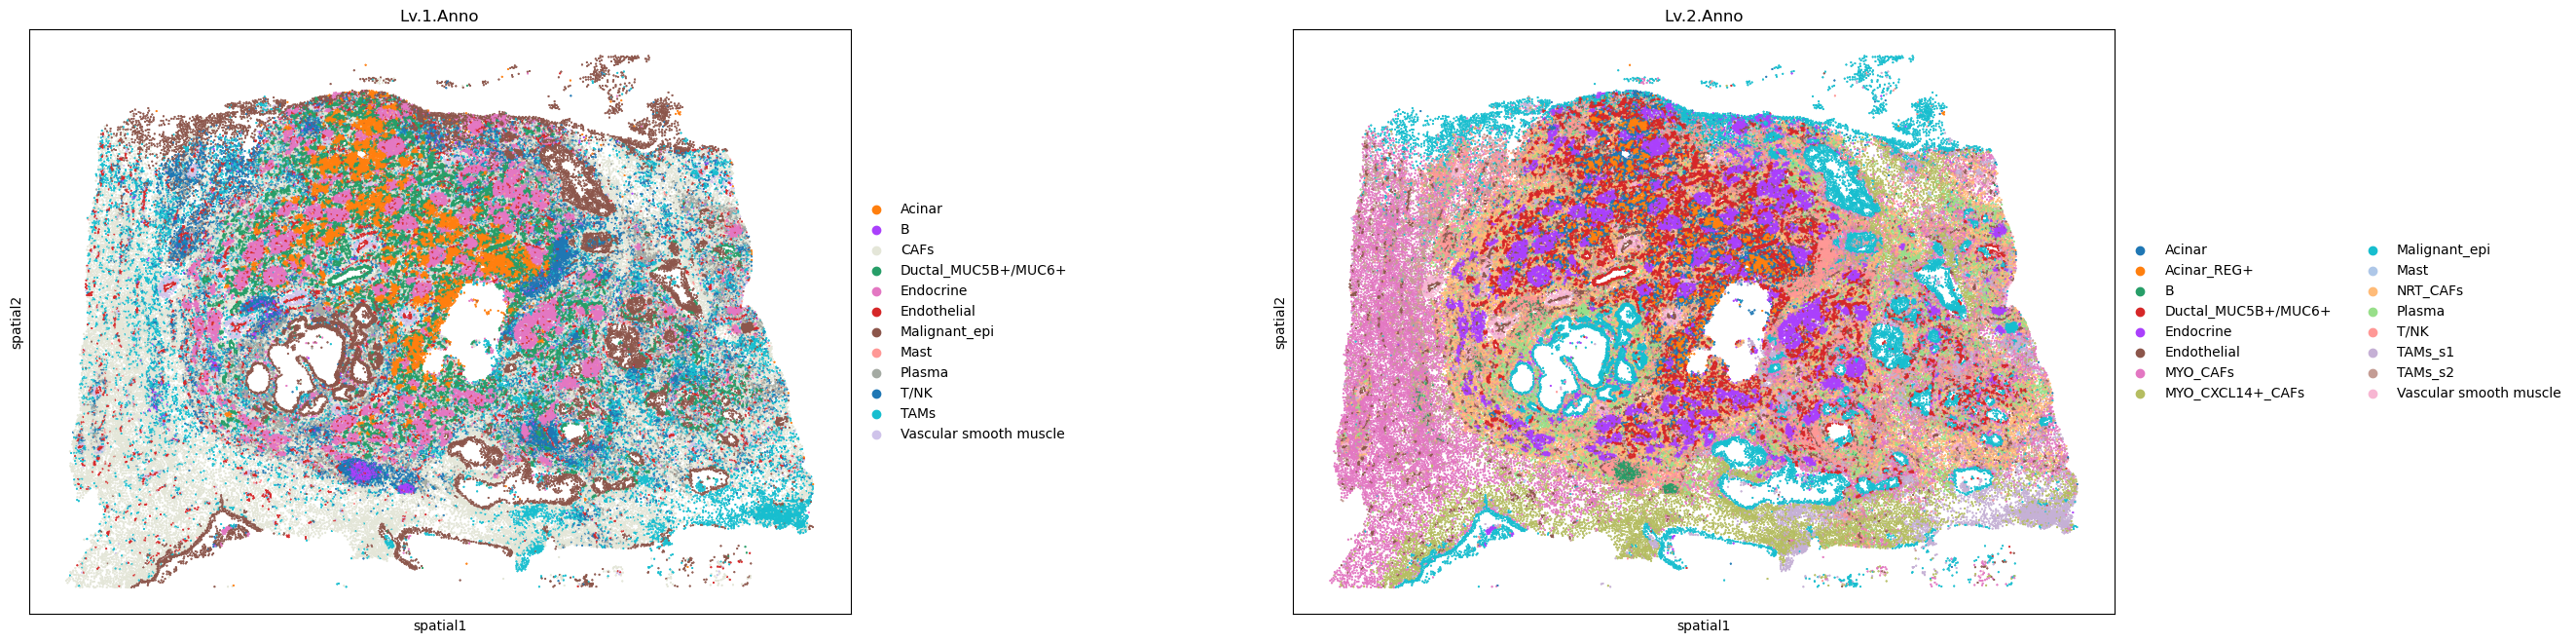

In [9]:
# Visualisation - at spatial context
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "Lv.1.Anno","Lv.2.Anno"
        #"leiden_2.0"
    ],
    wspace=0.4, figsize=(10,10)
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/homevol/huemail/.local/lib/python3.9/site-pa

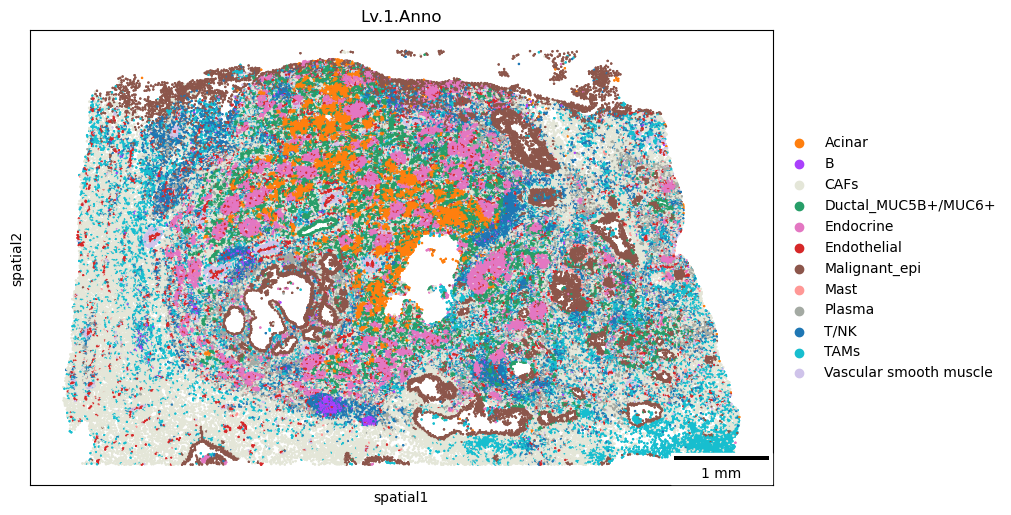

In [66]:
# Visualisation - at spatial context
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
       "Lv.1.Anno"
        #"leiden_2.0"
    ],
    crop_coord=[(0, 250, 8000, 4600)],
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    size=2,
    img=False,
    figsize=(10,10),
    #save='Fig1_spatial_2.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


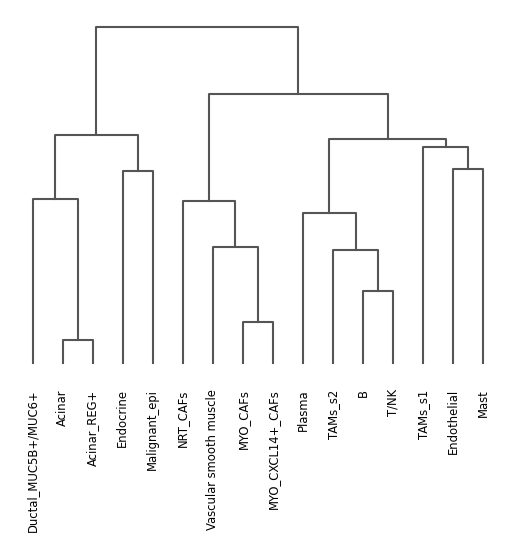

<Axes: >

In [82]:
# Running dendogram
sc.tl.dendrogram(adata, groupby = "anno_condense")
sc.pl.dendrogram(adata, groupby = "anno_condense")

In [97]:
# VERIFYING CLUSTER IDENTITY BEFORE PERFORMING SPATIAL STATISTICS
genes = ['CFTR', 'SLC4A4', 'ONECUT2','MUC6',#'MUC5B',#'SERPINA1','MUC3A',#'CALN1',
         'AMY2A','CPB1','CTRC','CELA3A',
         'REG3G','REG3A',"REG1B",
         'GCG','SST','INS',#'NRG1','SST', 'PPY'
         'TFF2','TFF1','MUC1','KRT19','KRT7',#'KRT17',#'KRT8','MUC1',
         'C7','ABCA6','ABCA10','SCN7A',
         'ACTA2','RGS5','PDGFRB',#'ACTN4','ITGA1',
         'COL11A1','FN1','CXCL14',#'IGF1',#'WNT5A',#'LEF1',
         'IGHG1','MZB1',
         'CD163','SELENOP','C1QA','HLA-DMB','HLA-DQA1',
         'MS4A1','CD19','IGHM','CD2','CD3D', 'CD3E', 'CD8A', 'IL7R','GZMK','GZMA',
         'SPP1','MARCO','OLR1', #'CHIT1','LIPA','APOE','APOC1','GRN'
         'VWF','PLVAP','KDR','FLT4','CCL21',
         'CPA3','MS4A2', 'KIT',
         ]

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


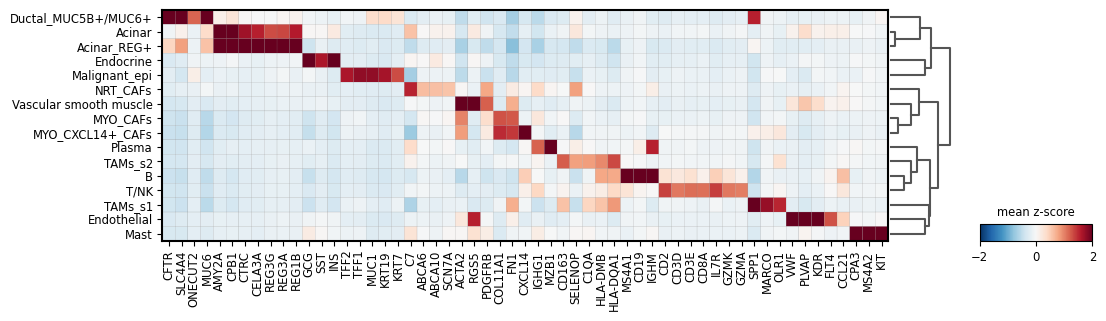

In [99]:
sc.pl.matrixplot(adata, genes, groupby='anno_condense', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',  figsize=(12, 3))

In [126]:
# VERIFYING CLUSTER IDENTITY BEFORE PERFORMING SPATIAL STATISTICS
genes_2 = ['AMY2A','CPB1','CTRC','CELA3A',
         'REG3G','REG3A',"REG1B",'CFTR', 'SLC4A4', 'ONECUT2','MUC6',#'MUC5B',#'SERPINA1','MUC3A',#'CALN1',
         'GCG','SST','INS',#'NRG1','SST', 'PPY'
         'TFF2','TFF1','MUC1','KRT19','KRT7',#'KRT17',#'KRT8','MUC1',
           'CPA3','MS4A2', 'KIT',
         'COL1A1','COL6A3','MMP2','CALD1',
         'ACTA2','PDGFRB','RGS5',#'ACTN4','ITGA1',
            'VWF','PLVAP','KDR',#'FLT4','CCL21',
           'CSF1R','CD163','HLA-DMB','HLA-DQA1',
         'IGHG1','MZB1',
         'IGHM','MS4A1','CD19','CD2','CD3D', 'CD3E', 'CD8A', 
         ]

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


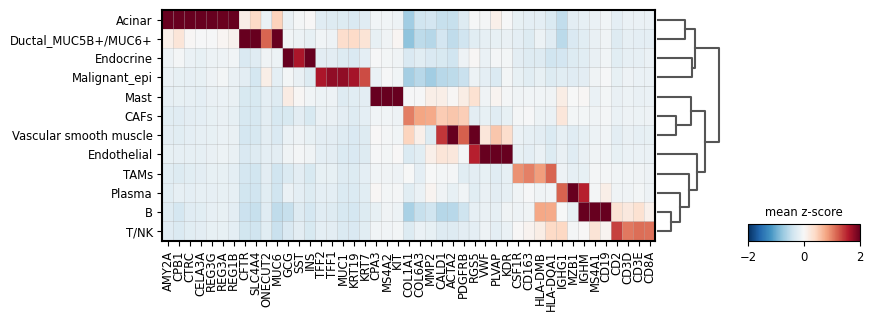

In [127]:
sc.pl.matrixplot(adata, genes_2, groupby='Lv.1.Anno', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',  figsize=(9, 3))

In [9]:
# USING THE SAME SET OF GENES in snRNA-seq
genes_anno = ['KRT19','KRT7','MUC1','TFF1','TFF2',
              'MUC5B','MUC6','ONECUT2',#'CALN1','SERPINA1','MUC3A',
              'CFTR', 'SLC4A4', 
              'REG3G','REG3A', #"REG1B",
              'AMY2A','CPB1','CTRC','CELA3A',
              'PDGFRB','RGS5','GJC1','TRPC6',
             'CALD1','COL1A1','FN1','COL6A3','COL11A1',
             'GCG','SST','INS',
              'VWF','PLVAP','KDR',#'FLT4',#'CCL21',
              'MS4A1','CD19','IGHM',
              'IGHG1','MZB1',
              'CD3D', 'CD3E','CD96','CD2',
             'CPA3','MS4A2', 'KIT',
              'CD163','CSF1R','SIGLEC1',
             ]

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


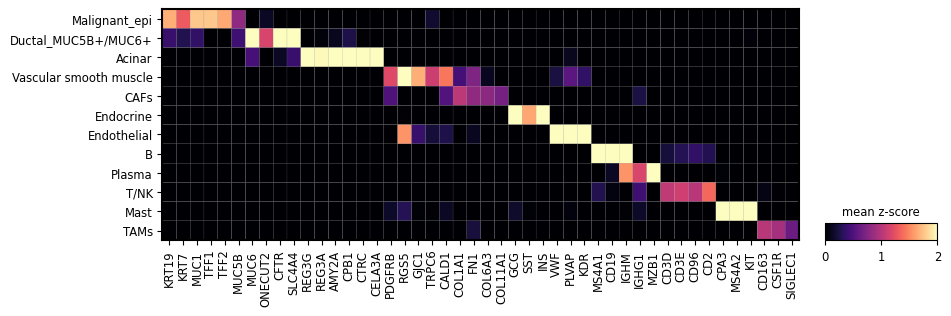

In [21]:
order = ['Malignant_epi','Ductal_MUC5B+/MUC6+','Acinar','Vascular smooth muscle',
         'CAFs', 'Endocrine','Endothelial','B','Plasma','T/NK','Mast','TAMs']
sc.pl.matrixplot(adata, genes_anno, groupby='Lv.1.Anno', 
                 categories_order = order,
                 #dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=0, vmax=2,  cmap='magma', figsize=(10, 3), save='Fig1_heatmap.pdf') #cmap='RdBu_r',

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


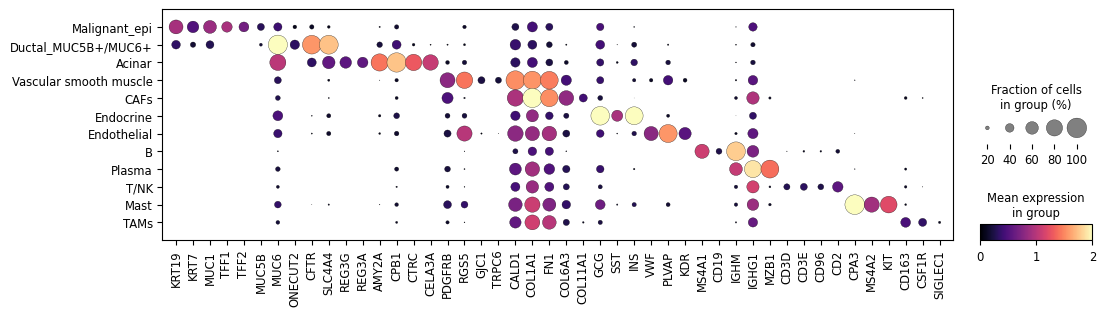

In [20]:
order = ['Malignant_epi','Ductal_MUC5B+/MUC6+','Acinar','Vascular smooth muscle',
         'CAFs', 'Endocrine','Endothelial','B','Plasma','T/NK','Mast','TAMs']
sc.pl.dotplot(adata, var_names = genes_anno , groupby='Lv.1.Anno', #swap_axes = True, 
               categories_order = order,
              figsize=(12, 3), vmax=2, vmin = 0, dot_min=0.1, cmap = 'magma',
             dendrogram=False, 
             #save = 'Sfig6.pdf'
             )

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

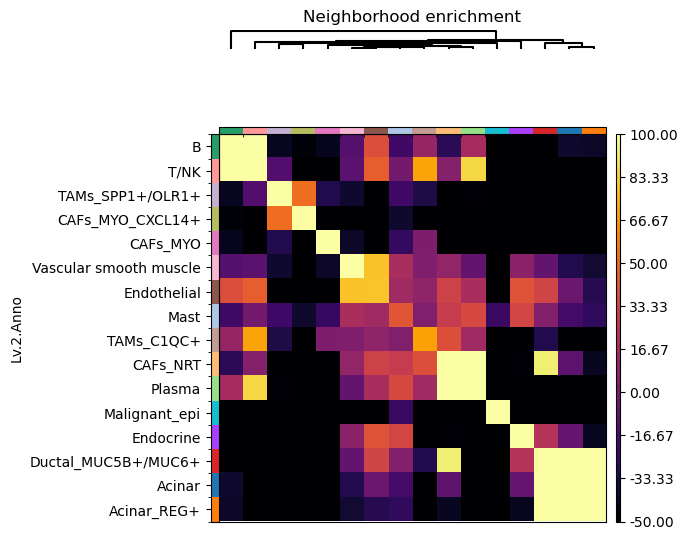

In [7]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", radius = 50) # can add radius and n_neighbour
#sq.gr.nhood_enrichment(adata, cluster_key="Lv.2.Anno", seed = 2323)
sq.pl.nhood_enrichment(
    adata,
    cluster_key="Lv.2.Anno",
    method="average",
    cmap="inferno",
    vmin=-50,
    vmax=100,
    figsize=(5, 5),
)

In [15]:
sq.gr.co_occurrence(
    adata,
    cluster_key="Lv.2.Anno",
    n_splits = 5, 
    n_jobs = 10
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [05:25<00:00, 21.73s/]


In [16]:
adata.uns['Lv.2.Anno_co_occurrence']

{'occ': array([[[           nan, 3.94543552e+00, 3.62255621e+00, ...,
          8.76672715e-02, 7.89311230e-02, 9.30588022e-02],
         [           nan, 3.80807209e+00, 3.63729858e+00, ...,
          4.43118997e-02, 4.82279137e-02, 5.54442406e-02],
         [           nan, 3.56112957e-01, 4.79735017e-01, ...,
          3.28252703e-01, 3.38723540e-01, 3.35666716e-01],
         ...,
         [           nan, 8.82973000e-02, 1.72010660e-01, ...,
          2.55280137e+00, 2.56452417e+00, 2.57043195e+00],
         [           nan, 6.07527912e-01, 6.04509473e-01, ...,
          1.08781862e+00, 1.06806862e+00, 1.02694952e+00],
         [           nan, 6.66947007e-01, 7.45530188e-01, ...,
          7.57317603e-01, 7.57799149e-01, 7.74521828e-01]],
 
        [[           nan, 4.24752092e+00, 3.92323470e+00, ...,
          5.37094288e-02, 4.96730916e-02, 4.65524979e-02],
         [           nan, 3.88176012e+00, 4.12978268e+00, ...,
          1.26233753e-02, 1.06159905e-02, 6.21809112e-03],


/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wi

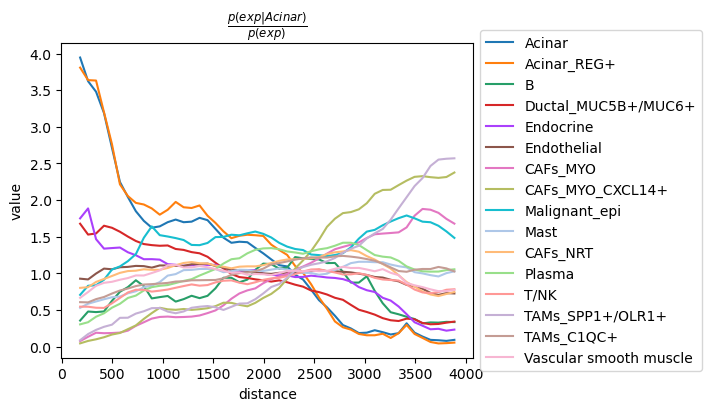

In [17]:
# Choosing the cell type to focus on
sq.pl.co_occurrence(
    adata,
    cluster_key= "Lv.2.Anno",
    clusters= "Acinar", # choose the cell type to focus on
    figsize=(7,4)
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wi

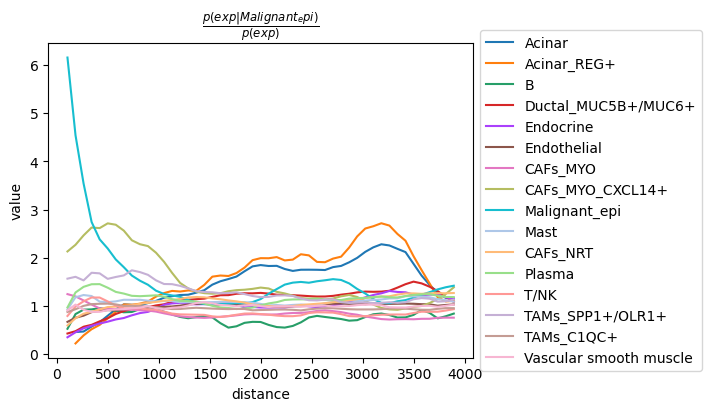

In [18]:
# Choosing the cell type to focus on
sq.pl.co_occurrence(
    adata,
    cluster_key= "Lv.2.Anno",
    clusters= "Malignant_epi", # choose the cell type to focus on
    figsize=(7,4)
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wi

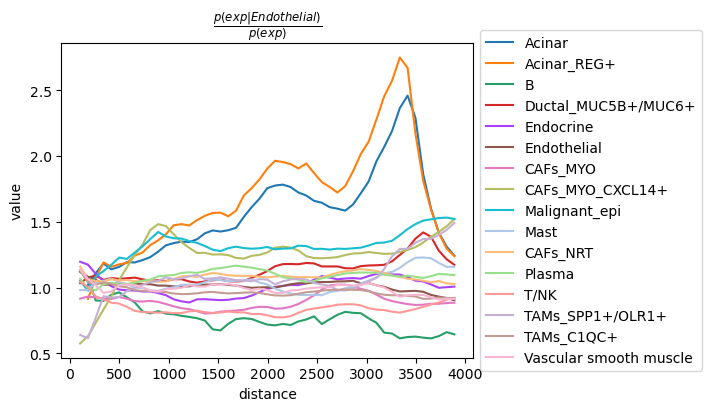

In [22]:
# Choosing the cell type to focus on
sq.pl.co_occurrence(
    adata,
    cluster_key= "Lv.2.Anno",
    clusters= "Endothelial", # choose the cell type to focus on
    figsize=(7,4)
)

In [157]:
# Compute Moran's I score: to determine spatially variable genes
# The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.04/s]


In [158]:
adata.uns["moranI"].head(30) # top genes that show strong spatial patterning

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
INS      0.805696        0.0  0.000002         0.0  0.009901  0.000006   
TFF1     0.757212        0.0  0.000002         0.0  0.009901  0.000006   
GCG      0.747752        0.0  0.000002         0.0  0.009901  0.000005   
MUC6     0.731473        0.0  0.000002         0.0  0.009901  0.000005   
IGHG1    0.720016        0.0  0.000002         0.0  0.009901  0.000005   
TFF2     0.716534        0.0  0.000002         0.0  0.009901  0.000006   
MUC5AC   0.688971        0.0  0.000002         0.0  0.009901  0.000004   
SST      0.674684        0.0  0.000002         0.0  0.009901  0.000004   
SLC4A4   0.650556        0.0  0.000002         0.0  0.009901  0.000004   
REG4     0.650161        0.0  0.000002         0.0  0.009901  0.000004   
REG1A    0.644929        0.0  0.000002         0.0  0.009901  0.000004   
KRT5     0.640667        0.0  0.000002         0.0  0.009901  0.000005   
SPP1     0.639165        0.0  0.000002         0.0  0.009901  0.000004   
CTRC     0.628374        0.0  0.000002         0.0  0.009901  0.000004   
CTRB2    0.626753        0.0  0.000002         0.0  0.009901  0.000004   
PRSS1    0.624071        0.0  0.000002         0.0  0.009901  0.000004   
CFTR     0.608036        0.0  0.000002         0.0  0.009901  0.000004   
AMY2A    0.599693        0.0  0.000002         0.0  0.009901  0.000004   
CELA3A   0.599538        0.0  0.000002         0.0  0.009901  0.000004   
CPB1     0.590427        0.0  0.000002         0.0  0.009901  0.000003   
PNLIP    0.587175        0.0  0.000002         0.0  0.009901  0.000003   
MUC1     0.574073        0.0  0.000002         0.0  0.009901  0.000005   
FN1      0.566570        0.0  0.000002         0.0  0.009901  0.000003   
COL11A1  0.563060        0.0  0.000002         0.0  0.009901  0.000003   
KRT19    0.562257        0.0  0.000002         0.0  0.009901  0.000004   
CXCL14   0.561672        0.0  0.000002         0.0  0.009901  0.000005   
C7       0.554163        0.0  0.000002         0.0  0.009901  0.000004   
MUC5B    0.551982        0.0  0.000002         0.0  0.009901  0.000003   
COL1A1   0.543331        0.0  0.000002         0.0  0.009901  0.000004   
REG3A    0.542522        0.0  0.000002         0.0  0.009901  0.000004   

         pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
INS                   0.0                0.0         0.010094  
TFF1                  0.0                0.0         0.010094  
GCG                   0.0                0.0         0.010094  
MUC6                  0.0                0.0         0.010094  
IGHG1                 0.0                0.0         0.010094  
TFF2                  0.0                0.0         0.010094  
MUC5AC                0.0                0.0         0.010094  
SST                   0.0                0.0         0.010094  
SLC4A4                0.0                0.0         0.010094  
REG4                  0.0                0.0         0.010094  
REG1A                 0.0                0.0         0.010094  
KRT5                  0.0                0.0         0.010094  
SPP1                  0.0                0.0         0.010094  
CTRC                  0.0                0.0         0.010094  
CTRB2                 0.0                0.0         0.010094  
PRSS1                 0.0                0.0         0.010094  
CFTR                  0.0                0.0         0.010094  
AMY2A                 0.0                0.0         0.010094  
CELA3A                0.0                0.0         0.010094  
CPB1                  0.0                0.0         0.010094  
PNLIP                 0.0                0.0         0.010094  
MUC1                  0.0                0.0         0.010094  
FN1                   0.0                0.0         0.010094  
COL11A1               0.0                0.0         0.010094  
KRT19                 0.0                0.0         0.010094  
CXCL14                0.0                0.0         0.01

In [ ]:
adata.uns["moranI"].tail(20) # top genes that show strong spatial patterning

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


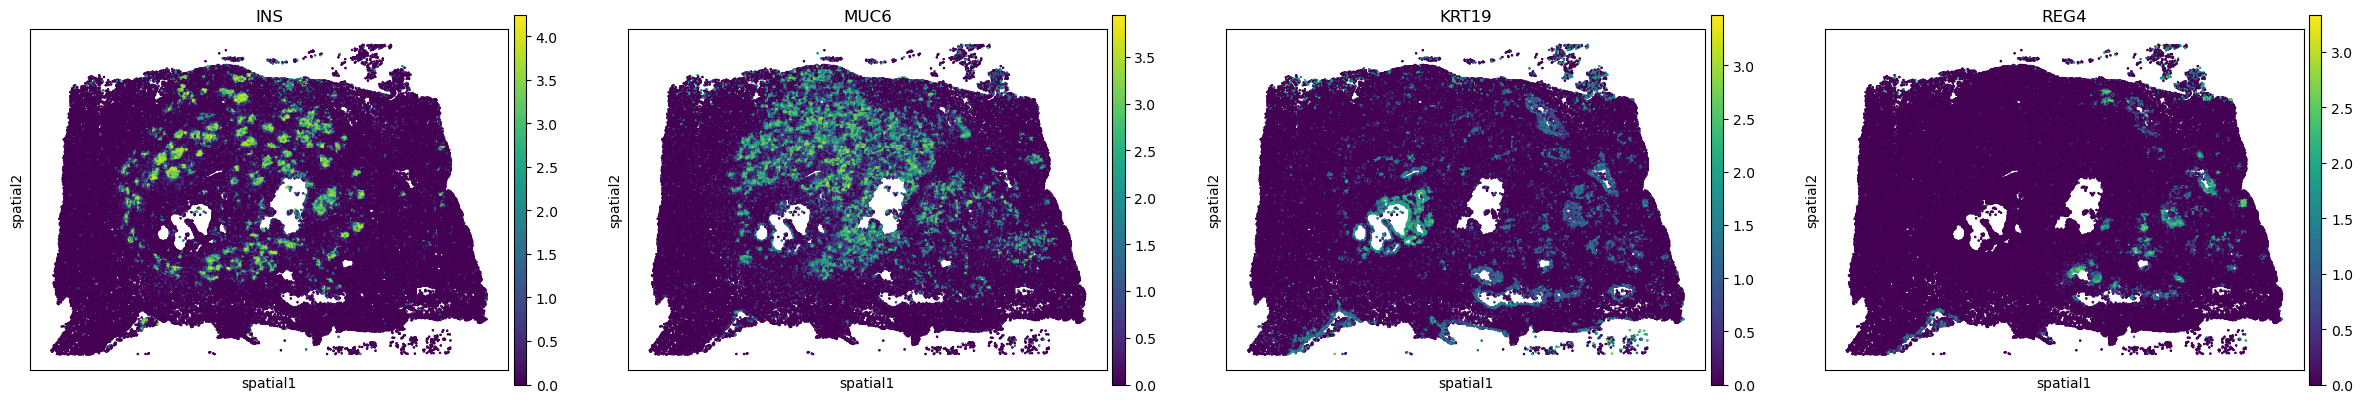

In [160]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "INS", 
        "MUC6", 
        "KRT19", 
        "REG4"
    ],
    shape=None,
    size=2,
    img=False,
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


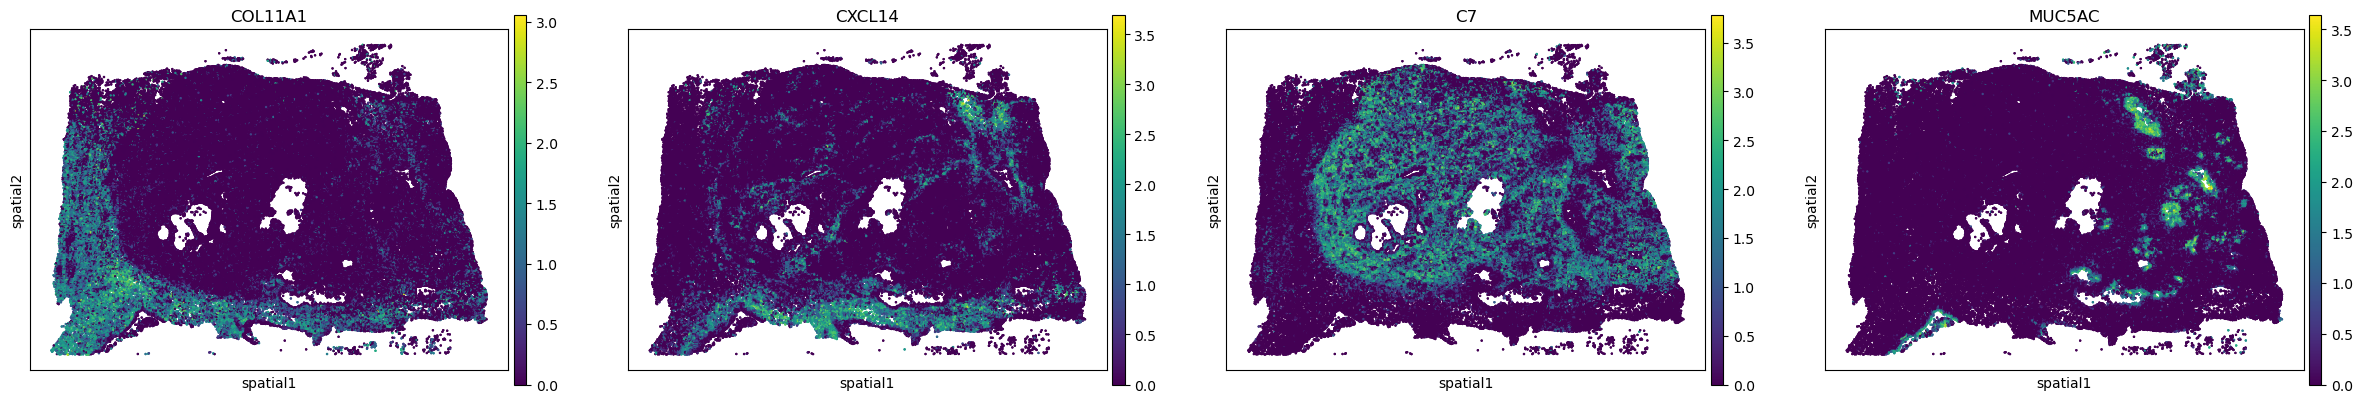

In [162]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "COL11A1", 
        "CXCL14", 
        "C7", 
        "MUC5AC"
    ],
    shape=None,
    size=2,
    img=False,
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


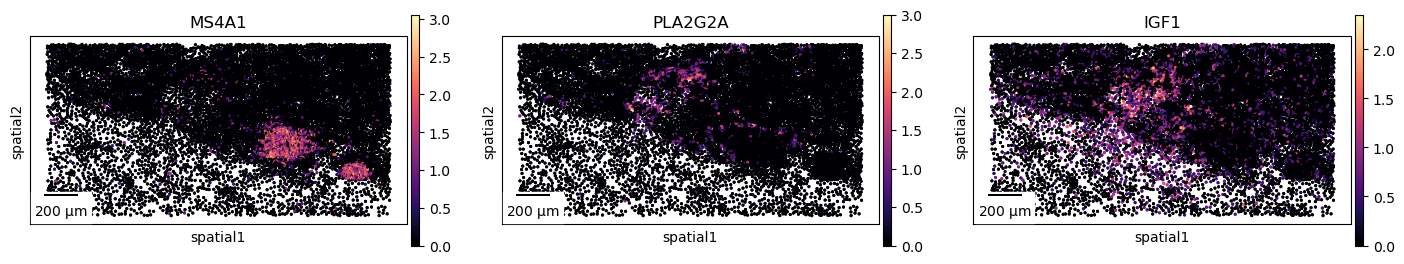

In [14]:
# Plotting a crop region - Figure related
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=["MS4A1","PLA2G2A","IGF1"],
    shape=None,
    crop_coord=[(2000, 3400, 4000, 4400)], #(x0, right, x1, bottom).
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower left"},
    size=6, figsize = (5,3),
    cmap='magma',
    img=False, save = 'FRCs.pdf'
)

In [8]:
pd.DataFrame(adata.uns['Lv.2.Anno_nhood_enrichment']['zscore']) #50microns

0           1            2           3           4          5   \
0   432.080690  579.700746   -38.059904  178.476965   -6.231038  -4.550312   
1   579.700746  626.474864   -39.438238  137.935081  -41.318658 -29.344253   
2   -38.059904  -39.438238  1719.356663  -59.054221  -61.611486  38.770318   
3   178.476965  137.935081   -59.054221  400.063867   22.465273  33.448205   
4    -6.231038  -41.318658   -61.611486   22.465273  622.491203  41.123441   
5    -4.550312  -29.344253    38.770318   33.448205   41.123441  79.197102   
6  -117.615172  -99.063090   -42.313946 -149.017917 -155.960462 -59.114349   
7   -91.655169  -77.977083   -47.538073 -140.599929 -135.062185 -85.654067   
8   -91.242717  -89.396000   -52.778010 -127.406450 -123.825109 -80.328288   
9   -19.247792  -25.453730   -20.212568    3.931682   34.669518  14.994060   
10   -9.696088  -40.899048   -27.680103   92.664643  -48.088470  33.112089   
11  -66.899727  -73.519583    17.080326  -66.970629  -62.552805  18.214579   
12  -83.385854  -86.527152   359.589150  -71.221003 -111.884425  45.966029   
13  -77.131146  -68.389235   -41.052499  -75.159100 -104.648400 -57.961364   
14  -61.153553  -71.206213    10.393082  -30.504122  -74.352343   8.762214   
15  -30.282690  -36.750728   -12.531315   -7.555126    7.158221  78.539665   

            6           7           8          9           10          11  \
0  -117.615172  -91.655169  -91.242717 -19.247792   -9.696088  -66.899727   
1   -99.063090  -77.977083  -89.396000 -25.453730  -40.899048  -73.519583   
2   -42.313946  -47.538073  -52.778010 -20.212568  -27.680103   17.080326   
3  -149.017917 -140.599929 -127.406450   3.931682   92.664643  -66.970629   
4  -155.960462 -135.062185 -123.825109  34.669518  -48.088470  -62.552805   
5   -59.114349  -85.654067  -80.328288  14.994060   33.112089   18.214579   
6   179.962786  -62.534020 -100.671113 -24.797275 -113.082984  -68.632813   
7   -62.534020  313.820730  -84.556669 -37.812827 -130.991817  -82.043185   
8  -100.671113  -84.556669  346.887291 -22.866185 -122.633585  -89.028183   
9   -24.797275  -37.812827  -22.866185  42.327921   28.676084   36.378342   
10 -113.082984 -130.991817 -122.633585  28.676084  146.475219  119.155407   
11  -68.632813  -82.043185  -89.028183  36.378342  119.155407  249.074032   
12  -71.577790  -91.842965  -89.476657  -1.671293    4.926653   84.994021   
13  -30.106979   51.503400  -50.021139 -19.783370  -77.635855  -48.728018   
14    1.978850  -88.684448  -90.826353   3.225045   39.352957   14.879907   
15  -39.022991  -71.932709  -57.367228  18.174791    9.509447   -7.585082   

            12          13         14          15  
0   -83.385854  -77.131146 -61.153553  -30.282690  
1   -86.527152  -68.389235 -71.206213  -36.750728  
2   359.589150  -41.052499  10.393082  -12.531315  
3   -71.221003  -75.159100 -30.504122   -7.555126  
4  -111.884425 -104.648400 -74.352343    7.158221  
5    45.966029  -57.961364   8.762214   78.539665  
6   -71.577790  -30.106979   1.978850  -39.022991  
7   -91.842965   51.503400 -88.684448  -71.932709  
8   -89.476657  -50.021139 -90.826353  -57.367228  
9    -1.671293  -19.783370   3.225045   18.174791  
10    4.926653  -77.635855  39.352957    9.509447  
11   84.994021  -48.728018  14.879907   -7.585082  
12  519.299086  -13.656094  69.976144  -10.172443  
13  -13.656094  438.153194 -32.293368  -37.317161  
14   69.976144  -32.293368  68.931178    2.222990  
15  -10.172443  -37.317161   2.222990  169.357605

In [179]:
adata.obs['anno_condense'].cat.categories

Index(['Acinar', 'Acinar_REG+', 'B', 'Ductal_MUC5B+/MUC6+', 'Endocrine',
       'Endothelial', 'MYO_CAFs', 'MYO_CXCL14+_CAFs', 'Malignant_epi', 'Mast',
       'NRT_CAFs', 'Plasma', 'T/NK', 'TAMs_s1', 'TAMs_s2',
       'Vascular smooth muscle'],
      dtype='object')

In [180]:
from pathlib import Path  
df = pd.DataFrame(adata.uns['anno_condense_nhood_enrichment']['zscore'])
df.columns = ['Acinar', 'Acinar_REG+', 'B', 'Ductal_MUC5B+/MUC6+', 'Endocrine',
       'Endothelial', 'MYO_CAFs', 'MYO_CXCL14+_CAFs', 'Malignant_epi', 'Mast',
       'NRT_CAFs', 'Plasma', 'T/NK', 'TAMs_s1', 'TAMs_s2',
       'Vascular smooth muscle']
df.index = ['Acinar', 'Acinar_REG+', 'B', 'Ductal_MUC5B+/MUC6+', 'Endocrine',
       'Endothelial', 'MYO_CAFs', 'MYO_CXCL14+_CAFs', 'Malignant_epi', 'Mast',
       'NRT_CAFs', 'Plasma', 'T/NK', 'TAMs_s1', 'TAMs_s2',
       'Vascular smooth muscle']

In [181]:
filepath = Path("/homevol/huemail/G000428_MaiLa/output/Submission/NhoodEnrichment/P10614_1_50um.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath) 

In [ ]:
# Tidy up the metadata
adata.obs['Lv.2.Anno'] = adata.obs['anno_condense'].copy()

# Updating names
update_dic = {
    "MYO_CAFs" : "CAFs_MYO",
    "MYO_CXCL14+_CAFs" : "CAFs_MYO_CXCL14+",
    "NRT_CAFs" : "CAFs_NRT",
    "TAMs_s1" : "TAMs_SPP1+/OLR1+",
    "TAMs_s2" : "TAMs_C1QC+"
}
adata.obs['Lv.2.Anno'] = adata.obs['Lv.2.Anno'].replace(update_dic)

In [ ]:
adata = sc.read_h5ad("/homevol/huemail/G000428_MaiLa/PDAC_submission_codes/objects/Xenium_0010614_Region1.h5ad")

In [ ]:
#Saving file
adata.write_h5ad("/homevol/huemail/G000428_MaiLa/PDAC_submission_codes/objects/Xenium_0010614_Region1.h5ad")

In [11]:
import pandas as pd

# Convert the entire count matrix to a dense array (if needed)
counts_matrix = adata.X.toarray()  # Use .toarray() if adata.X is a sparse matrix

# Create a DataFrame with the counts for all genes across all cells
df_all_counts = pd.DataFrame(
    counts_matrix,
    index=adata.obs_names,      # Cell barcodes as row index
    columns=adata.var.index     # Gene symbols as column headers
)

df_all_counts['broad_cell_class'] = adata.obs['Lv.1.Anno'].values
df_all_counts['Lv.2.Anno'] = adata.obs['Lv.2.Anno'].values
df_all_counts['transcript_counts'] = adata.obs['transcript_counts'].values
df_all_counts['x_location'] = adata.obs['x_centroid'].values
df_all_counts['y_location'] = adata.obs['y_centroid'].values

In [12]:
# List the last four columns that you want to move to the front
columns_to_move = ['x_location', 'y_location', 'broad_cell_class','Lv.2.Anno', 'transcript_counts']

# Create a new order for the columns
new_column_order = columns_to_move + [col for col in df_all_counts.columns if col not in columns_to_move]

# Reorder the DataFrame columns
df_all_counts = df_all_counts[new_column_order]

# Display the updated DataFrame
print(df_all_counts)

             x_location   y_location broad_cell_class      Lv.2.Anno  \
aaaagpjp-1  1648.765259  1335.705688             CAFs       CAFs_MYO   
aaaajjem-1  1664.844727  1335.242065    Malignant_epi  Malignant_epi   
aaaakjpn-1  1668.348999  1345.580444             T/NK           T/NK   
aaaaodjn-1  1653.104492  1349.438965             CAFs       CAFs_MYO   
aaabdbmm-1  1662.224609  1354.426147           Plasma         Plasma   
...                 ...          ...              ...            ...   
oifpnggh-1  7442.640137  3500.394287    Malignant_epi  Malignant_epi   
oigahbdm-1  7456.614258  3505.823486             CAFs       CAFs_MYO   
oigaknom-1  7478.774414  3511.542236           Acinar         Acinar   
oigbbegl-1  7451.488770  3516.247559             CAFs       CAFs_MYO   
oigbdjgg-1  7441.283691  3526.916992             CAFs       CAFs_MYO   

            transcript_counts    ABCA10  ABCA6  ACKR1     ACTA2     ACTN4  \
aaaagpjp-1                 42  0.000000    0.0    0.0  0.0

In [13]:
df_all_counts.to_csv("/homevol/huemail/G000428_MaiLa/PDAC_submission_codes/counts/PDAC_Xenium_0010614_region1_P065.csv", index=False)

In [14]:
import sys
# Check the size of the DataFrame in bytes
df_size = sys.getsizeof(df_all_counts)
print(f"Size of DataFrame in memory: {df_size / (1024 ** 2):.2f} MB")

Size of DataFrame in memory: 202.44 MB
